Are there patient endotypes with defective IFNg signaling?

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scvi
from matplotlib_venn import venn2

from utils import enrich, enrichr

Global seed set to 0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
2022-05-10 05:46:26.414606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-10 05:46:26.414654: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


scanpy==1.8.2 anndata==0.7.6 umap==0.5.2 numpy==1.20.3 scipy==1.5.3 pandas==1.3.4 scikit-learn==1.0.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3 pynndescent==0.5.5


## Load pre-trained model and saved anndata

In [4]:
lvae_lr_IFNg = scvi.model.SCANVI.load('fischer_models/2022-04-15_scanvi_IFNg_genes')
lvae_lr_IFNa = scvi.model.SCANVI.load('fischer_models/2022-04-15_scanvi_IFNa (b_d)_genes')

INFO     Using data from adata.layers["counts"]                                              


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 224506 cells, 18023 vars, 5       
         batches, 12 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 224506 cells, 18023 vars, 5       
         batches, 12 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  


In [5]:
fischer = lvae_lr_IFNg.adata[lvae_lr_IFNg.adata.obs.batch_data == 'fischer']  # get fischer
covid = sc.read('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/211001_annot_patient_integrated.h5ad')
covid = covid[covid.obs.treatment != 'nan']
covid

View of AnnData object with n_obs × n_vars = 221974 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'used_for_scvi'
    uns: 'cell_type_colors', 'hvg', 'infected_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
# subsample and then combine because both datasets are too large to work with
sc.pp.subsample(covid, .5)
adata = fischer.concatenate(covid[covid.obs.infected == 'False'], uns_merge='first')
adata

AnnData object with n_obs × n_vars = 117290 × 18023
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'batch_data', 'patients', 'sample_ID', 'data_set', 'severity', 'location', 'condition', 'age', 'sex', 'virus_positive', 'PBMC_leiden_29', 'patient_category', 'reactive_clonotype', 'published_meta_celltype', 'published_celltype', 'harmonized_celltype', 'T_cell_type', 'size_factors', 'pct_mitochondrial', 'severity_virus', 'treatment_scanvi'
    var: 'used_for_scvi-0-0', 'highly_variable-1-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0', 'coef-0', 'marker_genes-0', 'used_for_scvi-1'
    uns: '_scvi', 'hvg', 'cell_

In [7]:
fischer.obs.patients.value_counts()

BIH-CoV-15                 14523
BIH-CoV-04                  7758
BIH-CoV-12                  6732
BIH-CoV-07                  5323
BIH-CoV-01                  3646
BIH-CoV-06                  2973
BIH-CoV-16                  2927
BIH-CoV-14                  2307
BIH-CoV-17                  2194
BIH-CoV-10                  1774
BIH-CoV-05                  1540
BIH-CoV-11                   954
BIH-CoV-09                   861
BIH-Con-01                   834
BIH-CoV-02                   691
BIH-CoV-18                   577
BIH-CoV-13                   536
BIH-CoV-03                   493
BIH-Con-03                   461
BIH-CoV-19                   444
BIH-Con-02                   395
S4                           373
S1                           364
S6                           326
BIH-CoV-08                   320
S3                           312
S2                           308
Patient 1 (GT_6, 17888)      295
BIH-Con-04                   275
BIH-Con-05                   242
muc17884  

Trying to set attribute `.uns` of view, copying.


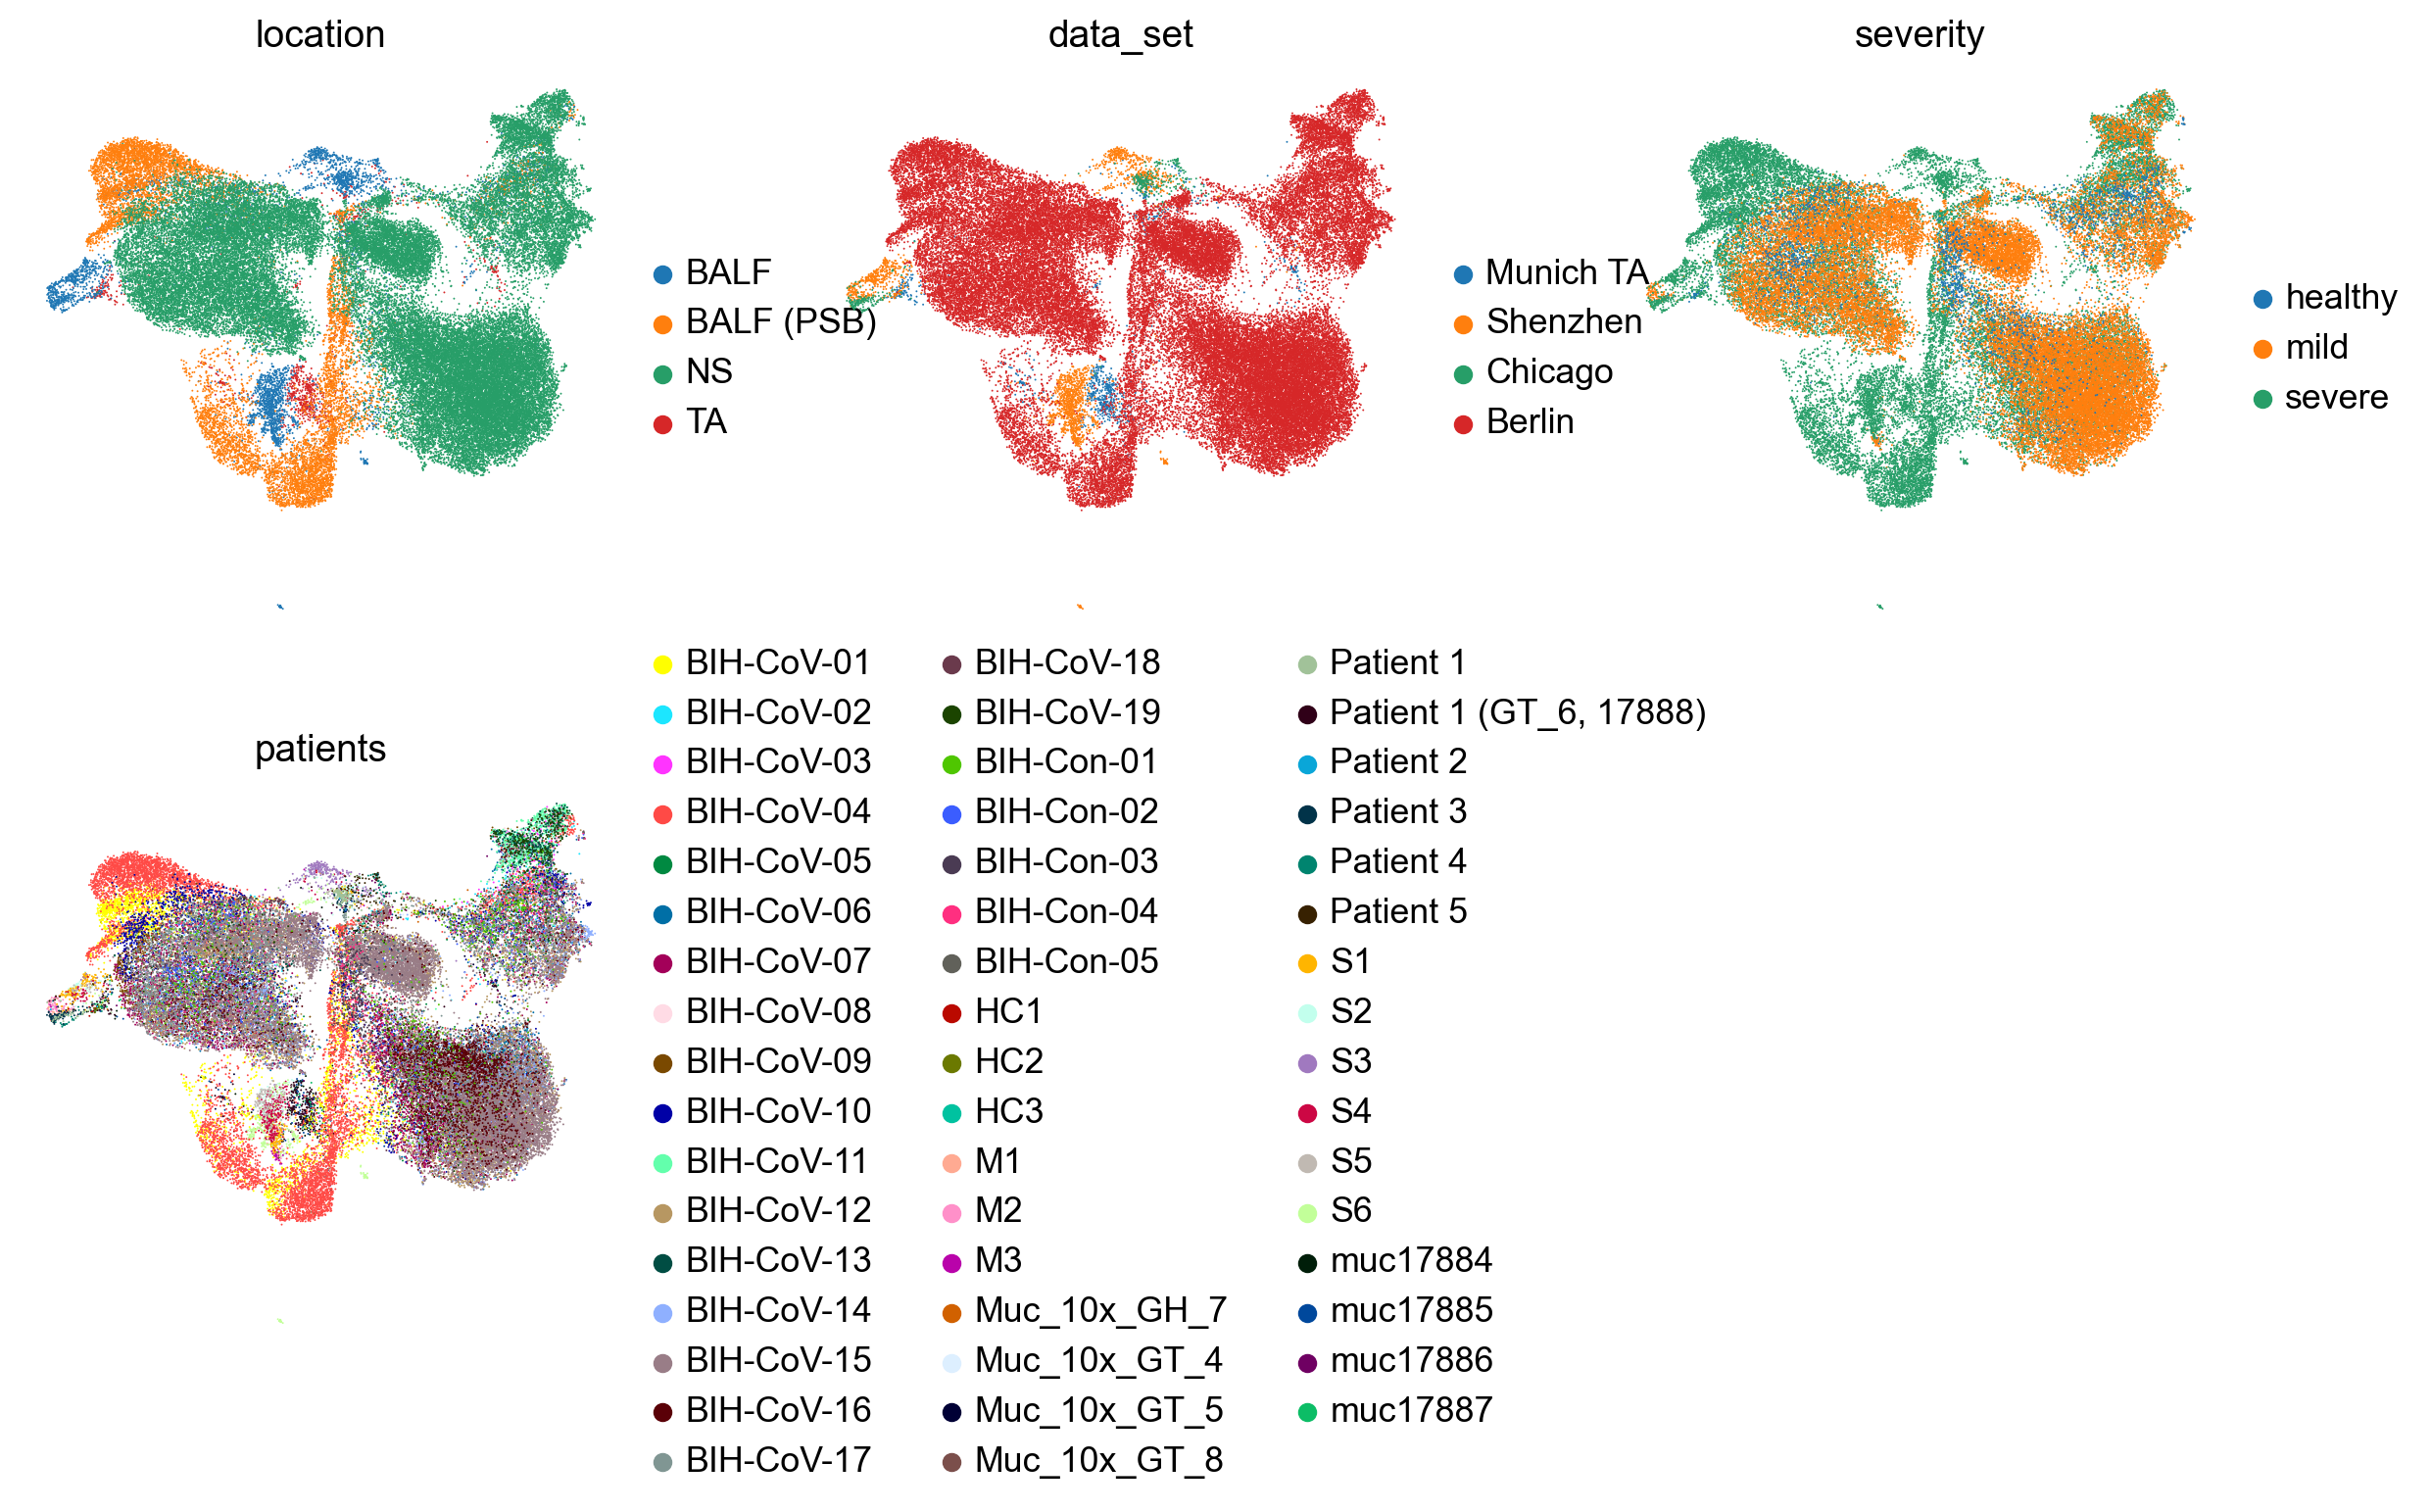

In [8]:
sc.pl.umap(fischer, color=['location', 'data_set', 'severity', 'patients'], ncols=3)

## Predict

In [9]:
adata.obs["treatment_predicted_IFNg"] = lvae_lr_IFNg.predict(adata)
adata.obs["treatment_predicted_IFNa"] = lvae_lr_IFNa.predict(adata)

adata.obsm["X_scANVI_IFNg"] = lvae_lr_IFNg.get_latent_representation(adata)

In [10]:
%%time
sc.pp.neighbors(adata, use_rep="X_scANVI_IFNg")
sc.tl.umap(adata)

CPU times: user 5min 15s, sys: 27.9 s, total: 5min 43s
Wall time: 2min 27s


In [ ]:
sc.pl.umap(adata, color=['batch_data', 'cell_type', 'treatment_predicted_IFNg', 'treatment'], wspace=.4)

Add probabilities too:

In [12]:
treatment_index_dict = dict(zip(adata.obs.treatment.cat.categories, range(len(adata.obs.treatment.cat.categories))))
# type II IFN
z1 = lvae_lr_IFNg.get_latent_representation(adata)
preds = lvae_lr_IFNg.module.classifier(torch.from_numpy(z1)).detach().numpy()
adata.obs['classifier_proba_IFNg'] = preds[:, treatment_index_dict['IFNg']]
# type I IFN
z1 = lvae_lr_IFNa.get_latent_representation(adata)
preds = lvae_lr_IFNa.module.classifier(torch.from_numpy(z1)).detach().numpy()
adata.obs['classifier_proba_IFNa'] = preds[:, treatment_index_dict['IFNa (b_d)']]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


Quantitative performance check:

In [13]:
from external_utils import plot_proportions
from matplotlib import cm

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


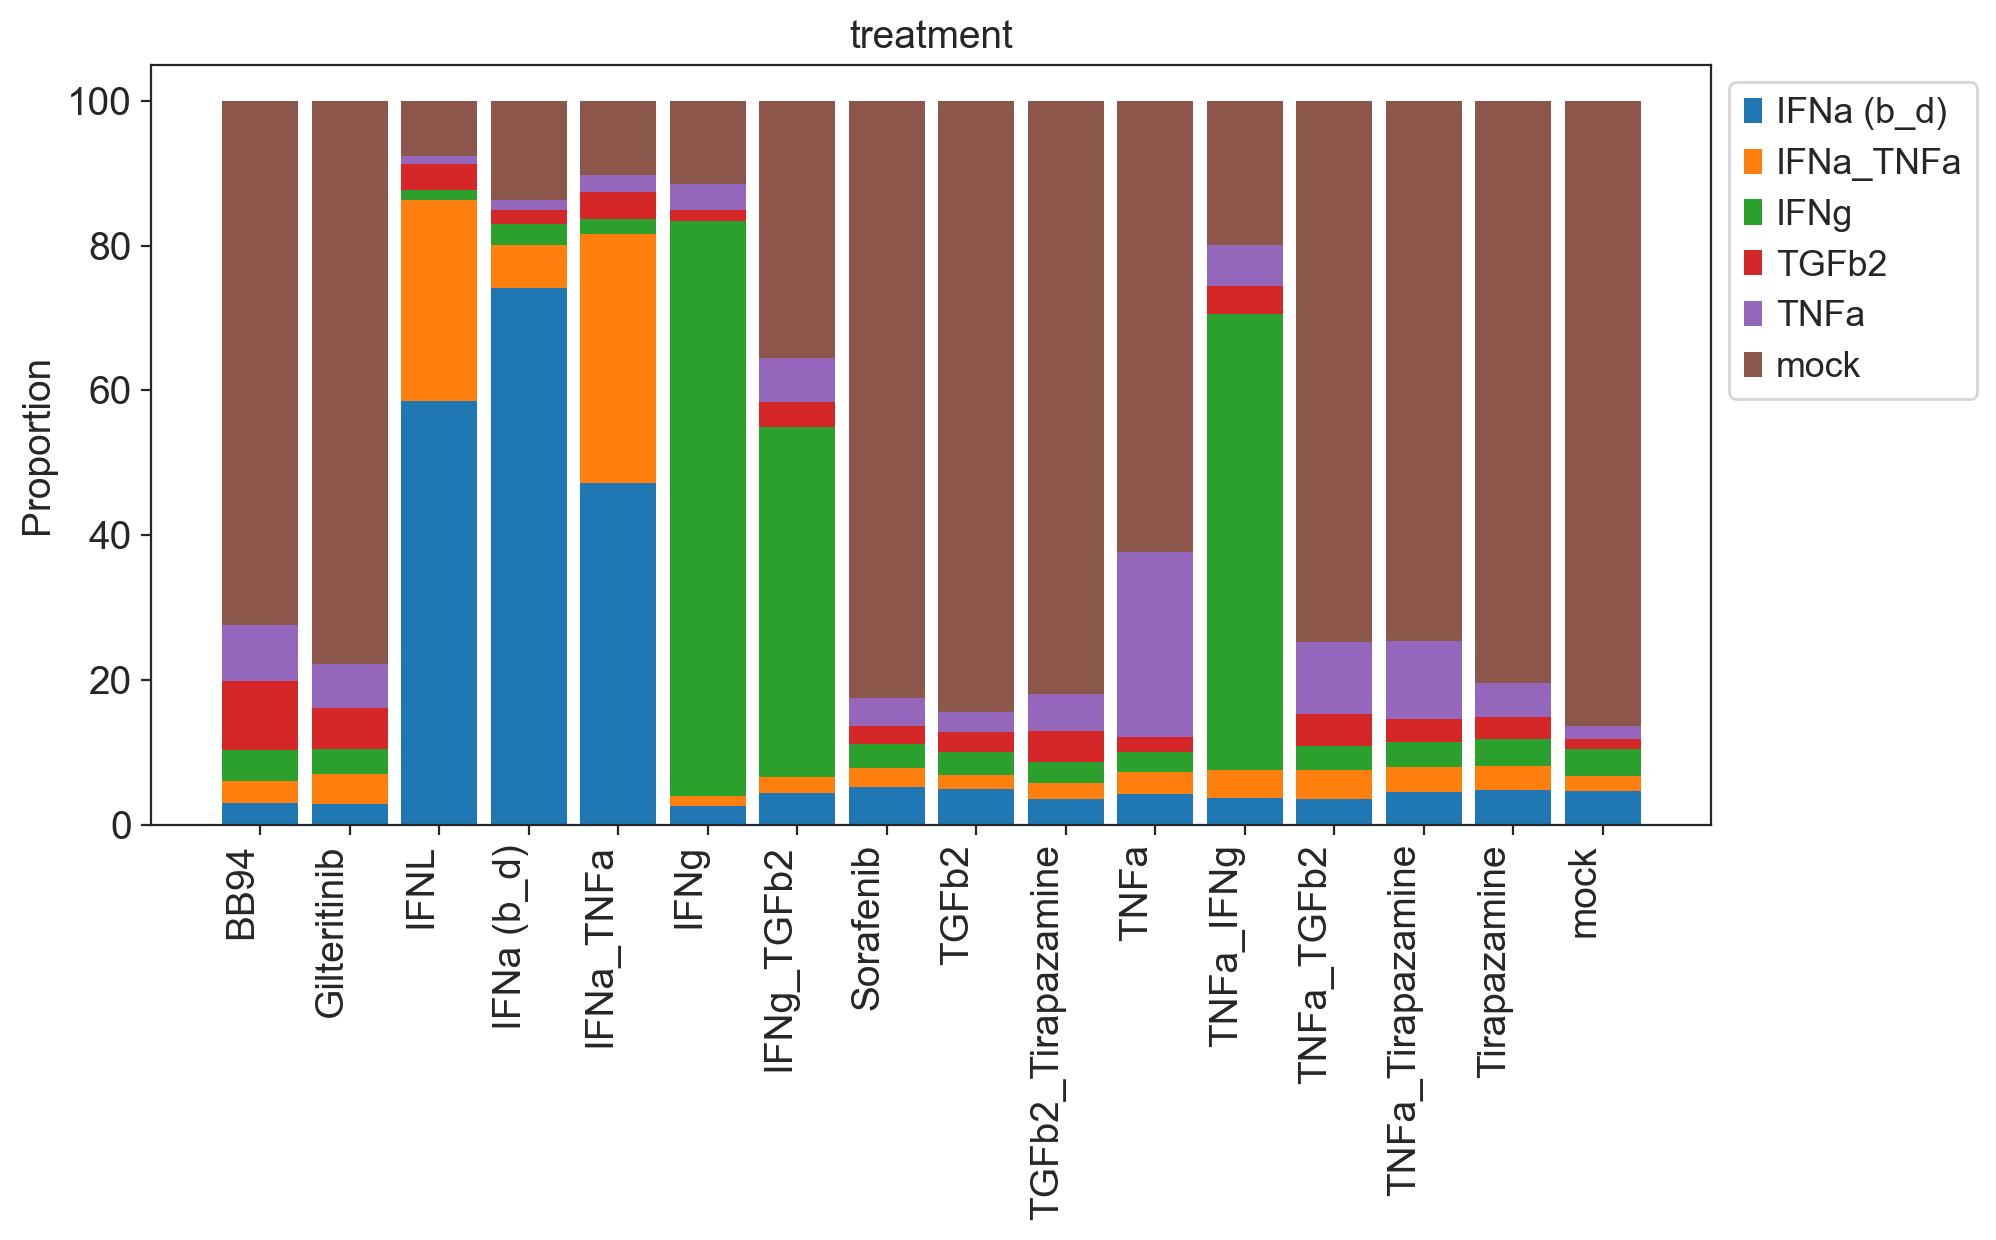

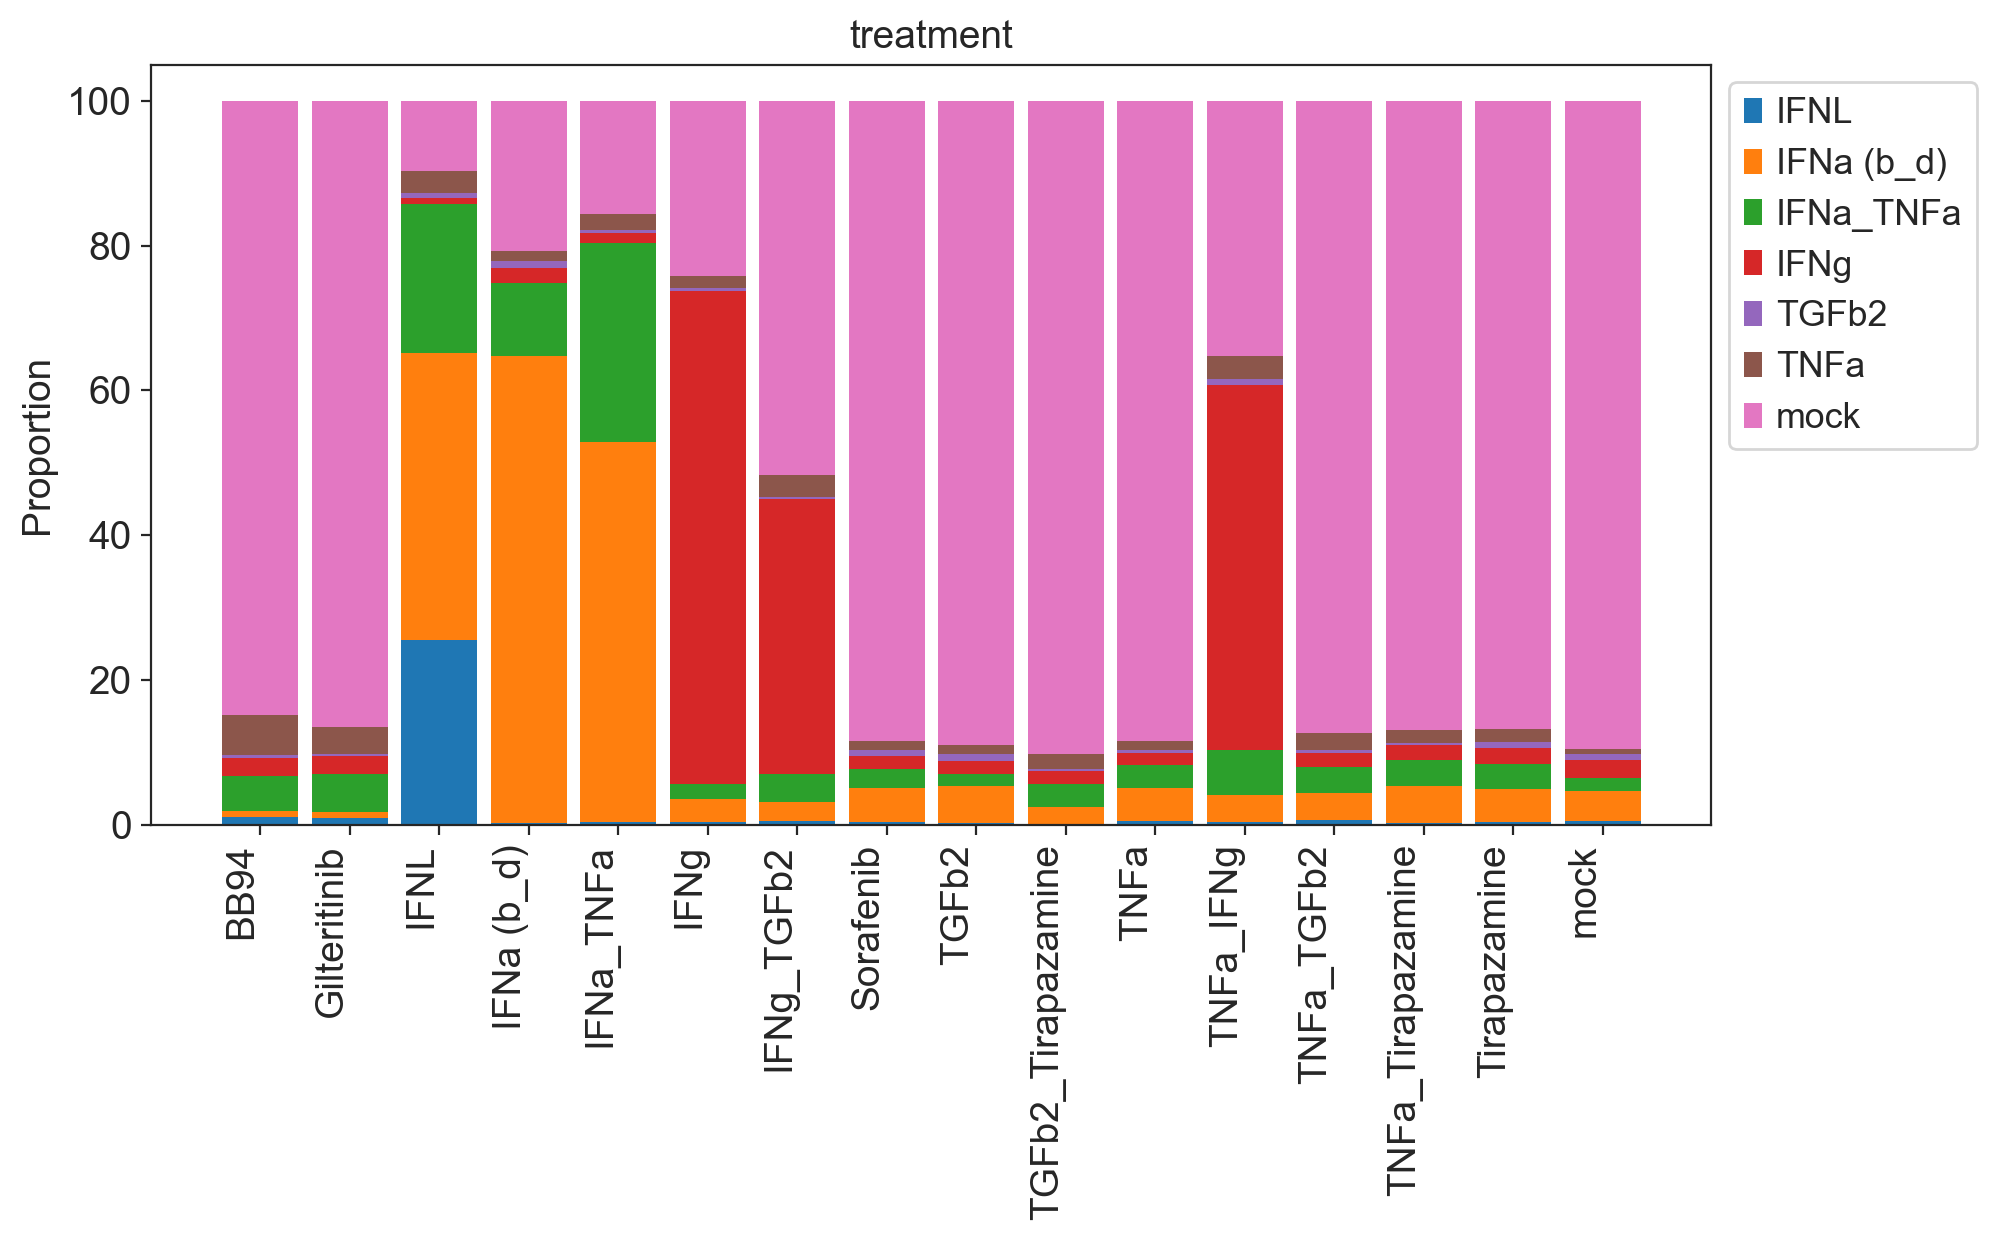

In [14]:
plot_proportions(
    adata[adata.obs.batch_data != 'fischer'], 'treatment_predicted_IFNg', 'treatment',
    figsize=(10, 5), cmap=cm.get_cmap('tab10')
)
plot_proportions(
    adata[adata.obs.batch_data != 'fischer'], 'treatment_predicted_IFNa', 'treatment',
    figsize=(10, 5), cmap=cm.get_cmap('tab10')
);

Given the discrepancy with TGFb not being labeled as TGFb even among the original ALI data, we would expect the TGFb predictions to be spurious. But I'm also curious what's driving the label otherwise. The IFNa model looks much better.

### Decipher what drives type I/II interferon response prediction by calculating feature importance (skip)

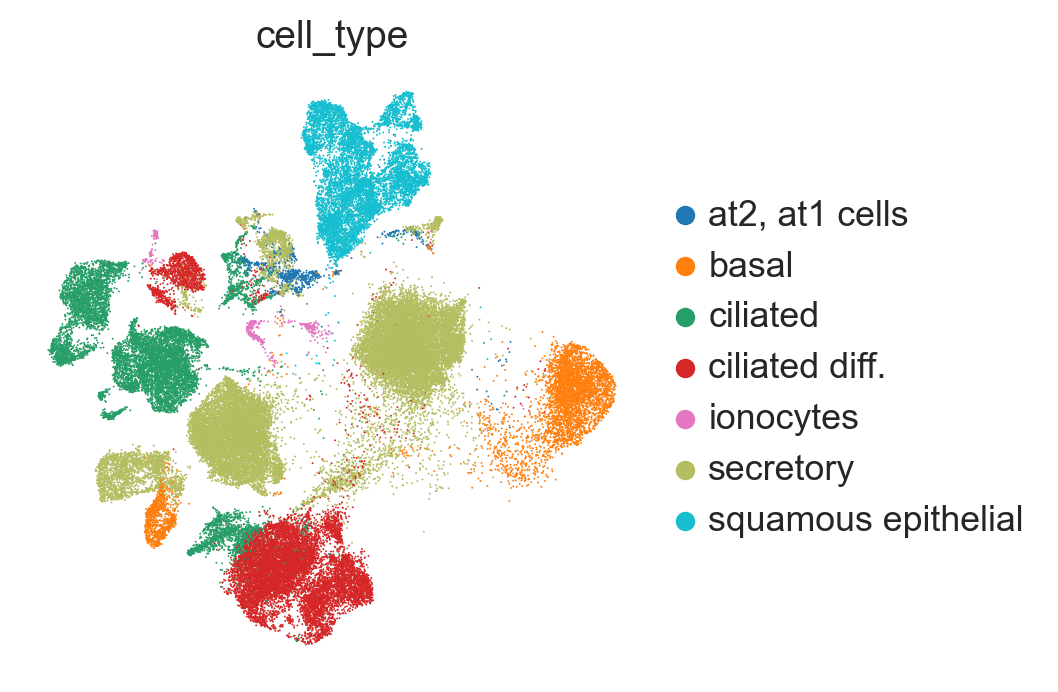

In [15]:
subset = adata[adata.obs.batch_data == 'fischer']
sc.pl.umap(subset, color='cell_type')

In [16]:
import random
indices = subset.obs.index.values.copy()
random.shuffle(indices)
shuffled_counts = subset[indices].layers['counts']
IFNg_values = subset.obs['classifier_proba_IFNg'].values
IFNa_values = subset.obs['classifier_proba_IFNa'].values

In [ ]:
%%time
import gc
change_mat_IFNg = []
change_mat_IFNa = []
for i, gene in enumerate(subset.var_names):
    # permute one gene in the adata
    new_adata = subset.copy()
    new_adata.layers['counts'][:, i] = shuffled_counts[:, i]
    # get prediction probabilities for IFNg
    z1 = lvae_lr_IFNg.get_latent_representation(new_adata)
    preds = lvae_lr_IFNg.module.classifier(torch.from_numpy(z1)).detach().numpy()
    change_mat_IFNg.append(IFNg_values - preds[:, treatment_index_dict['IFNg']])
    # get prediction probabilities for IFNa
    z1 = lvae_lr_IFNa.get_latent_representation(new_adata)
    preds = lvae_lr_IFNa.module.classifier(torch.from_numpy(z1)).detach().numpy()
    change_mat_IFNa.append(IFNa_values - preds[:, treatment_index_dict['IFNa (b_d)']])

    # I have a leak oof
    if i % 200 == 0:
        gc.collect()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [ ]:
# create feature anndata and save
import anndata as ad
import scipy
for t, change_mat in [('IFNg', change_mat_IFNg), ('IFNa', change_mat_IFNa)]
    feature_adata = ad.AnnData(X=scipy.sparse.csr_matrix(np.array(change_mat).T), obs=subset.obs.copy(), var=subset.var.copy())
    feature_adata.obsm = subset.obsm.copy()
    feature_adata.write(f'2022-05-01_scanvi_{t}_genes_fischer_feature_adata.h5ad')

In [ ]:
'hi'

## Examine feature importance

In [ ]:
IFNg_features = sc.read('2022-05-01_scanvi_IFNg_genes_fischer_feature_adata.h5ad')
IFNa_features = sc.read('2022-05-01_scanvi_IFNa_genes_fischer_feature_adata.h5ad')

In [ ]:
for t, feature_adata in [('IFNg', IFNg_features), ('IFNa', IFNa_features)]:
    feature_adata.layers['abs'] = np.abs(feature_adata.X.toarray())
    feature_adata.var['sum'] = feature_adata.layers['abs'].sum(axis=0)
    sig_genes = feature_adata.var.sort_values(by='sum', ascending=False).index[:20]
    
    for gb in ['cell_type', 'patients', 'severity']:
        dp = sc.pl.dotplot(
            feature_adata[feature_adata.obs.treatment_predicted == f],
            var_names=sig_genes, groupby=gb, layer='abs', colorbar_title='mean feature\nimportance score',
            vmax=.1, return_fig=True, title='fischer importance'
        )
        dp.add_totals().show()
        # the same plot but expression
        dp = sc.pl.dotplot(adata[adata.obs.batch_data == 'fischer'], var_names=sig_genes, groupby=gb, title='fischer expression', return_fig=True)
        dp.add_totals().show()
        try:
            dp = sc.pl.dotplot(adata[adata.obs.batch_data != 'fischer'], var_names=sig_genes, groupby=gb, title='ALI expression', return_fig=True)
            dp.add_totals().show()
        except IndexError:  # key doesn't exist
            pass

Does it make sense that some patients have high or low type I/II interferon scores?

## Plot response per patient

Conclusion: hard to distinguish between actual response and confounders.

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


treatment_predicted,IFNa (b_d),IFNa_TNFa,IFNg,TGFb2,TNFa,mock
0,0.879227,0.038647,0.113527,0.214976,0.009662,1.000000
1,0.802395,1.000000,0.025948,0.249501,0.000000,0.056886
2,1.000000,0.271795,0.164103,0.897436,0.005128,0.087179
3,0.292498,0.327565,1.000000,0.683576,0.021643,0.358614


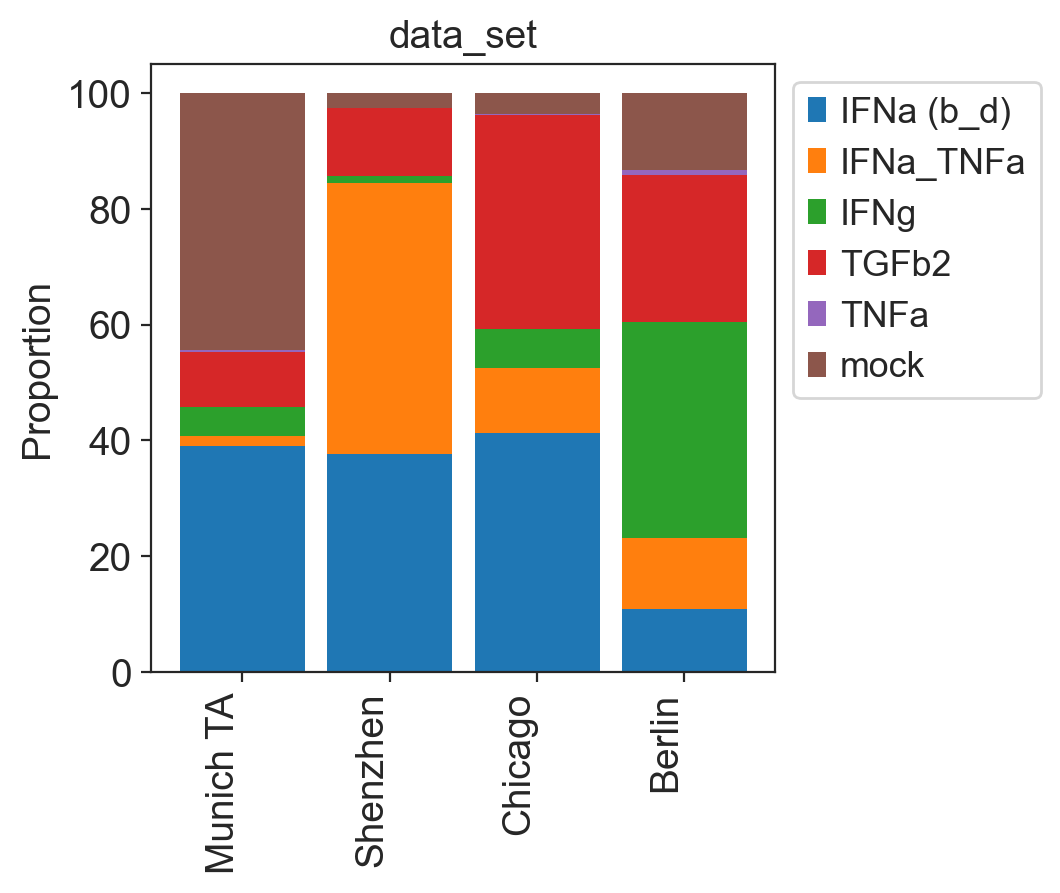

In [75]:
p = plot_proportions(
    adata[(adata.obs.batch_data == 'fischer')], 'treatment_predicted', 'data_set', cmap=cm.get_cmap('tab10')
)
p.to_df().div(p.to_df().max(axis=1), axis=0)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


treatment_predicted,IFNa (b_d),IFNa_TNFa,IFNg,TGFb2,TNFa,mock
0,0.953947,1.000000,0.359962,0.781955,0.074248,0.370301
1,0.002549,0.001275,0.052440,0.567553,0.019483,1.000000
2,0.299511,0.336246,1.000000,0.537721,0.013576,0.095923
3,0.879227,0.038647,0.113527,0.214976,0.009662,1.000000


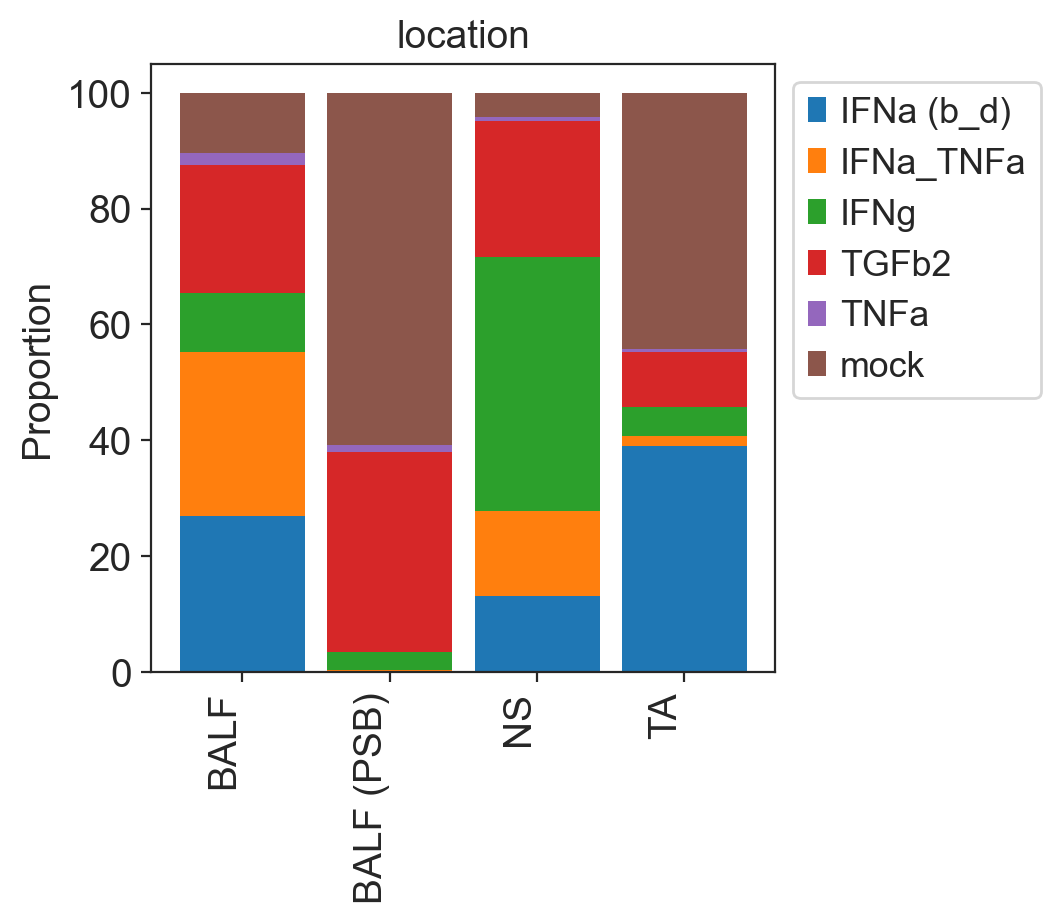

In [72]:
p = plot_proportions(
    adata[(adata.obs.batch_data == 'fischer')], 'treatment_predicted', 'location', cmap=cm.get_cmap('tab10')
)
p.to_df().div(p.to_df().max(axis=1), axis=0)

treatment_predicted,IFNa (b_d),IFNa_TNFa,IFNg,TGFb2,TNFa,mock
0,378.0,258.0,823.0,537.0,22.0,248.0
1,3849.0,5049.0,13821.0,6529.0,154.0,1050.0
2,3542.0,2938.0,7362.0,8419.0,303.0,7044.0


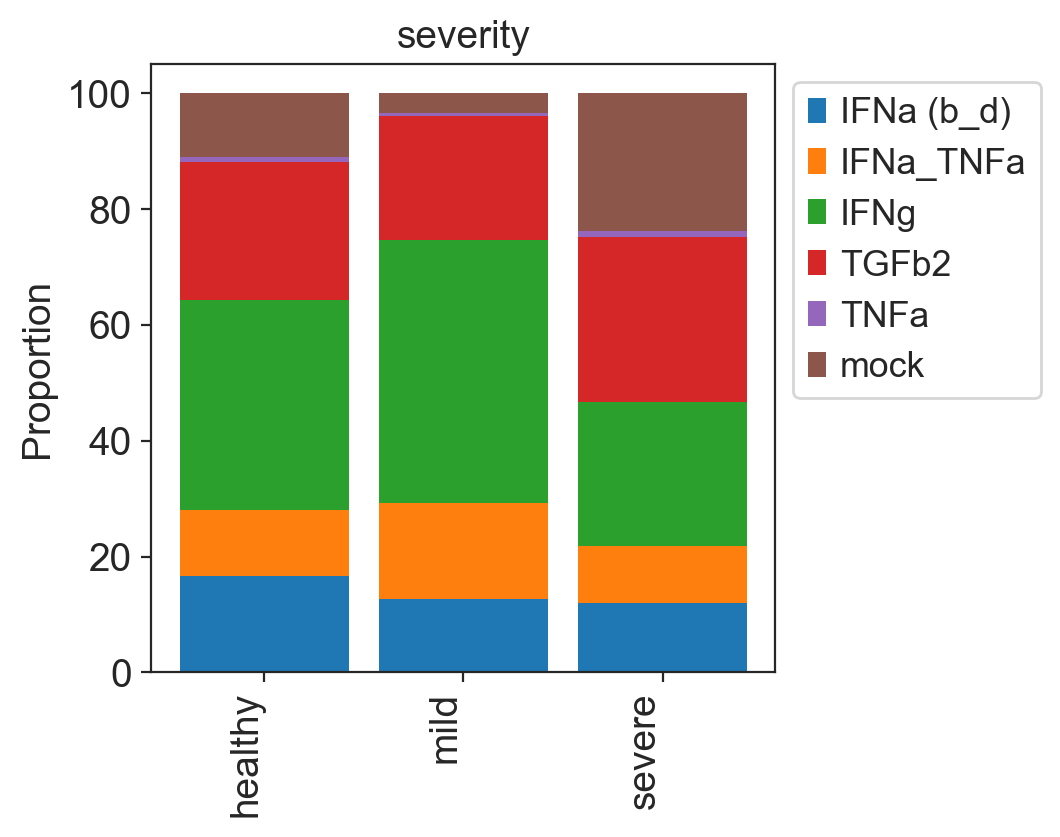

In [61]:
p = plot_proportions(
    adata[(adata.obs.batch_data == 'fischer')], 'treatment_predicted', 'severity', cmap=cm.get_cmap('tab10')
)
p.to_df().div(p.to_df().max(axis=1), axis=0)

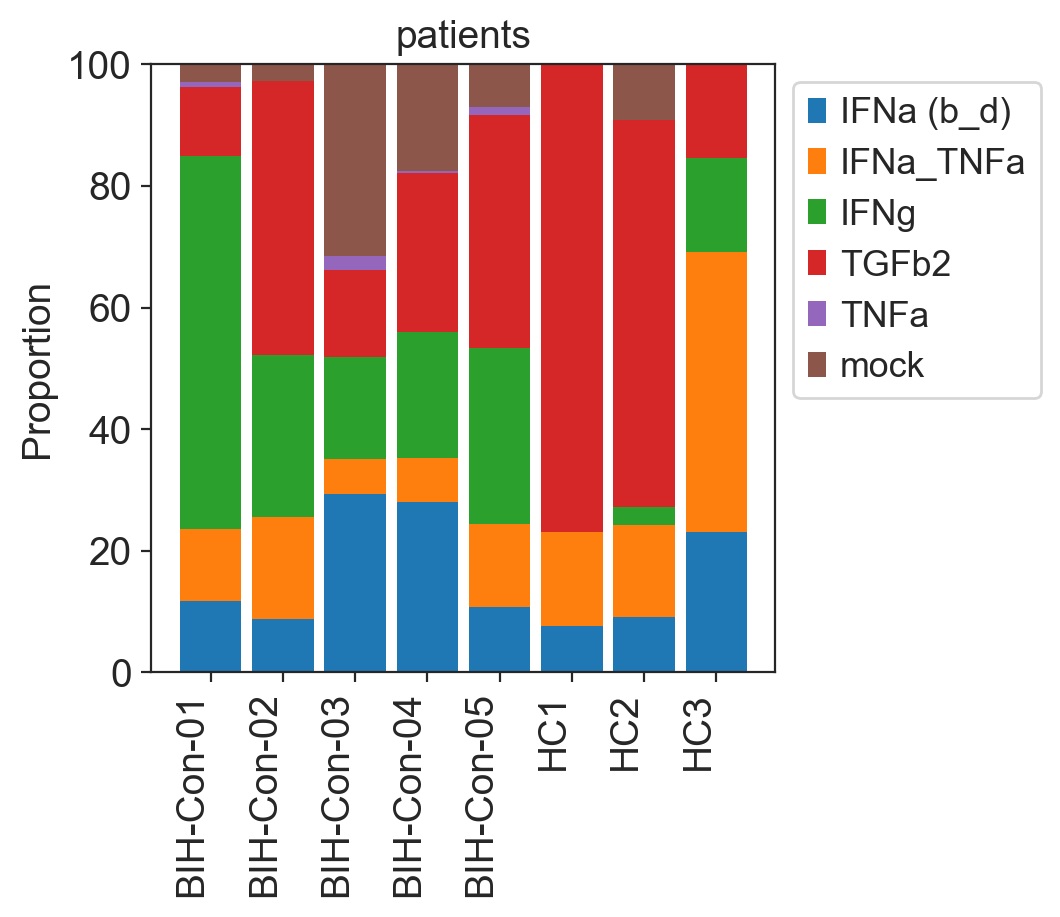

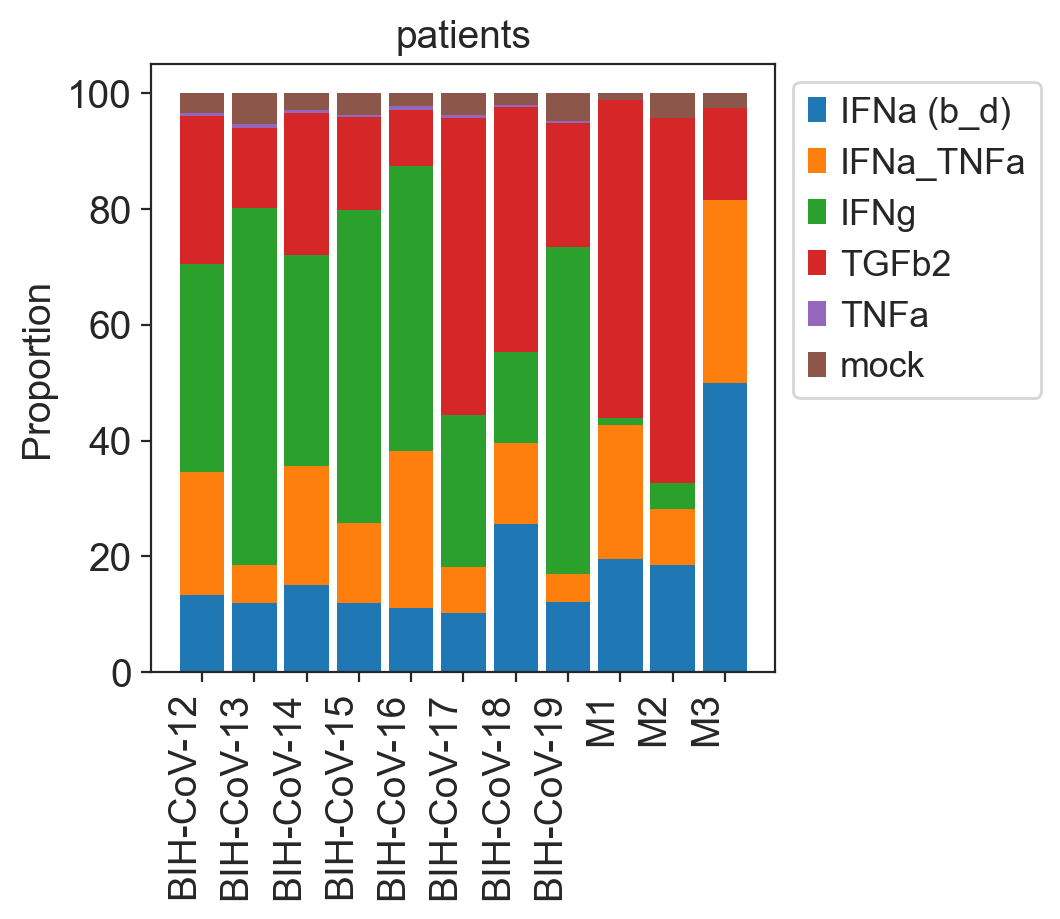

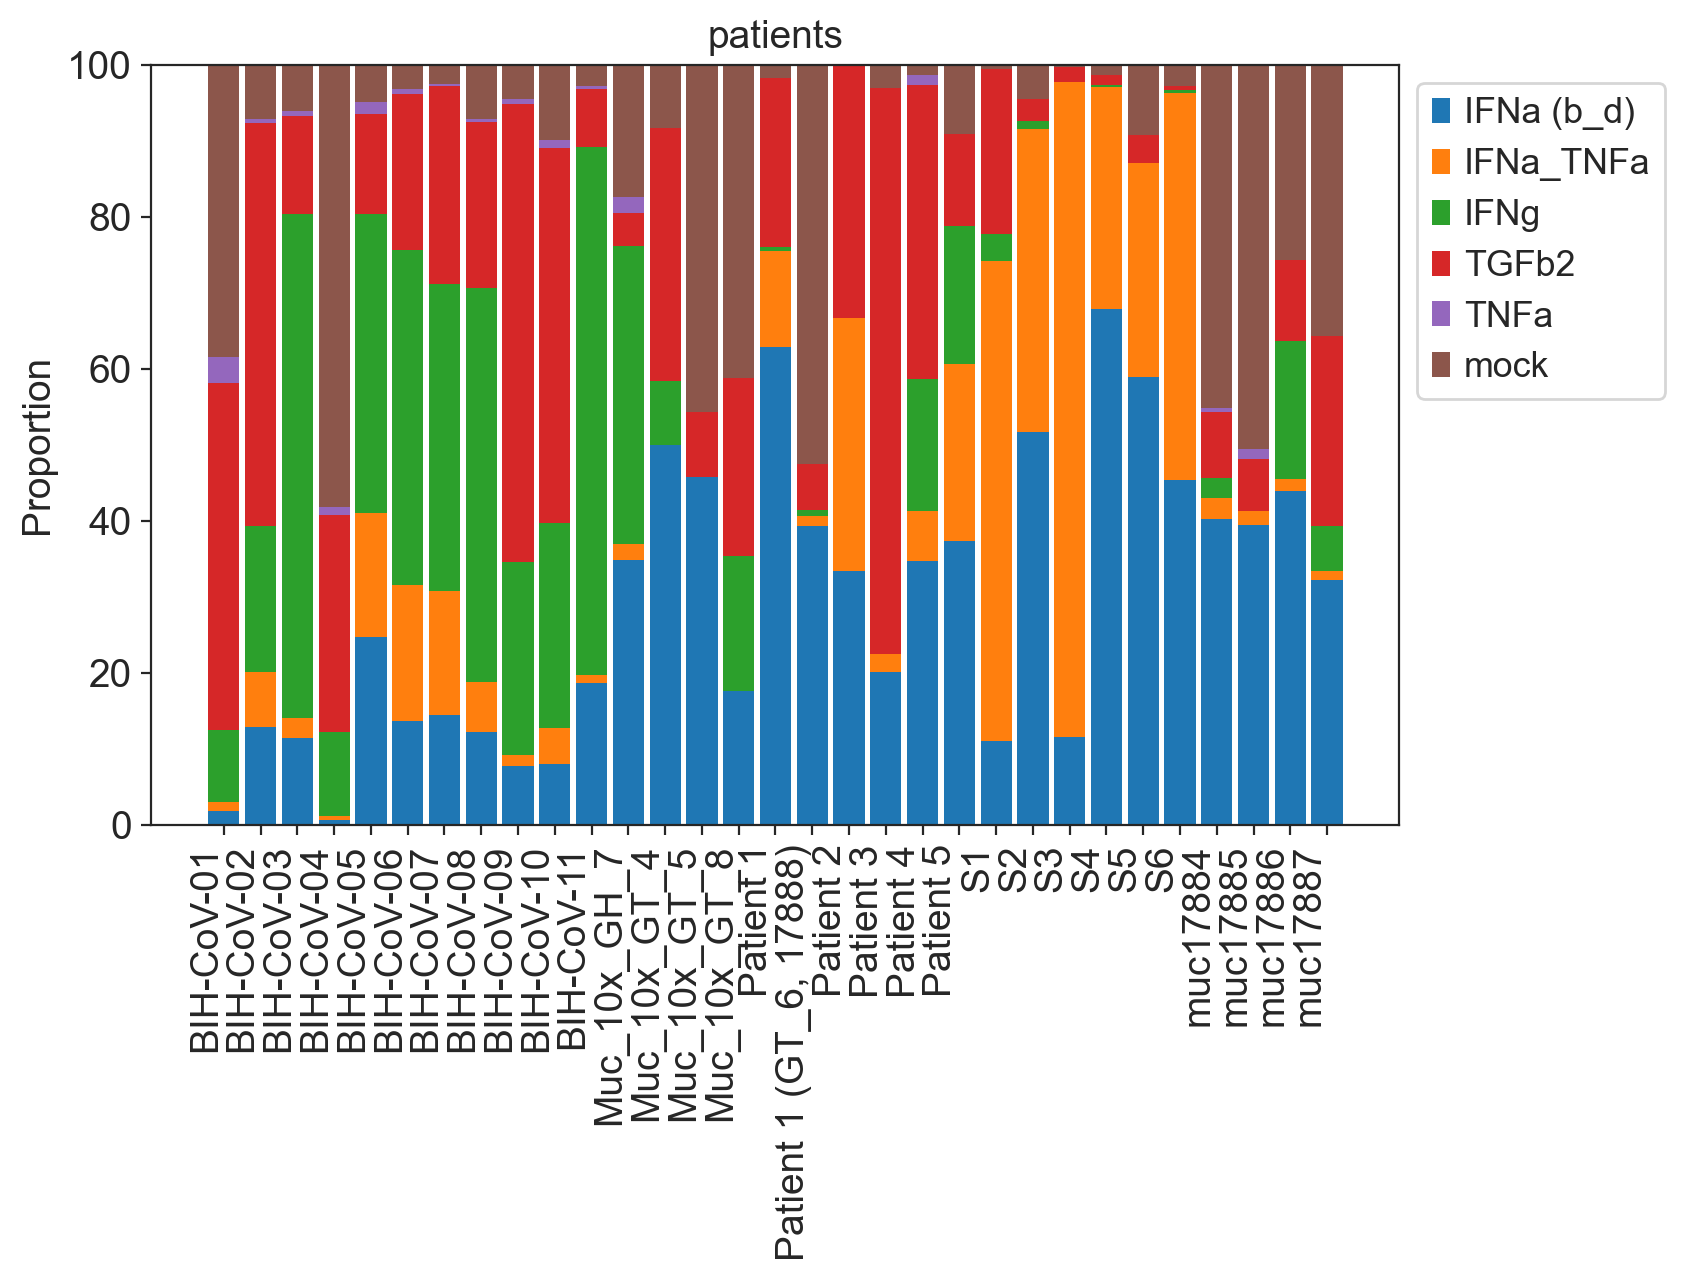

In [56]:
proportions = plot_proportions(
    adata[(adata.obs.batch_data == 'fischer') & (adata.obs.severity == 'healthy')], 'treatment_predicted', 'patients', cmap=cm.get_cmap('tab10')
)
proportions = plot_proportions(
    adata[(adata.obs.batch_data == 'fischer') & (adata.obs.severity == 'mild')], 'treatment_predicted', 'patients', cmap=cm.get_cmap('tab10')
)
proportions = plot_proportions(
    adata[(adata.obs.batch_data == 'fischer') & (adata.obs.severity == 'severe')], 'treatment_predicted', 'patients', cmap=cm.get_cmap('tab10'),
    figsize=(8, 5)
)

As one plot:

In [ ]:
adata.obs['ID'] = adata.obs.severity.astype(str) + '_' + adata.obs.data_set.astype(str) + '_' + adata.obs.location.astype(str) + '_' + adata.obs.patients.astype(str)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


treatment_predicted,IFNa (b_d),IFNa_TNFa,IFNg,TGFb2,TNFa,mock
0,0.191781,0.193738,1.000000,0.185910,0.013699,0.046967
1,0.196629,0.370787,0.589888,1.000000,0.000000,0.061798
2,0.931035,0.186207,0.531034,0.455172,0.075862,1.000000
3,1.000000,0.259740,0.740260,0.935065,0.012987,0.623377
4,0.279570,0.354839,0.752688,1.000000,0.032258,0.182796
5,0.100000,0.200000,0.000000,1.000000,0.000000,0.000000
6,0.142857,0.238095,0.047619,1.000000,0.000000,0.142857
7,0.500000,1.000000,0.333333,0.333333,0.000000,0.000000
8,0.370814,0.592807,1.000000,0.710624,0.012815,0.095907
9,0.193353,0.105740,1.000000,0.223565,0.009063,0.087613


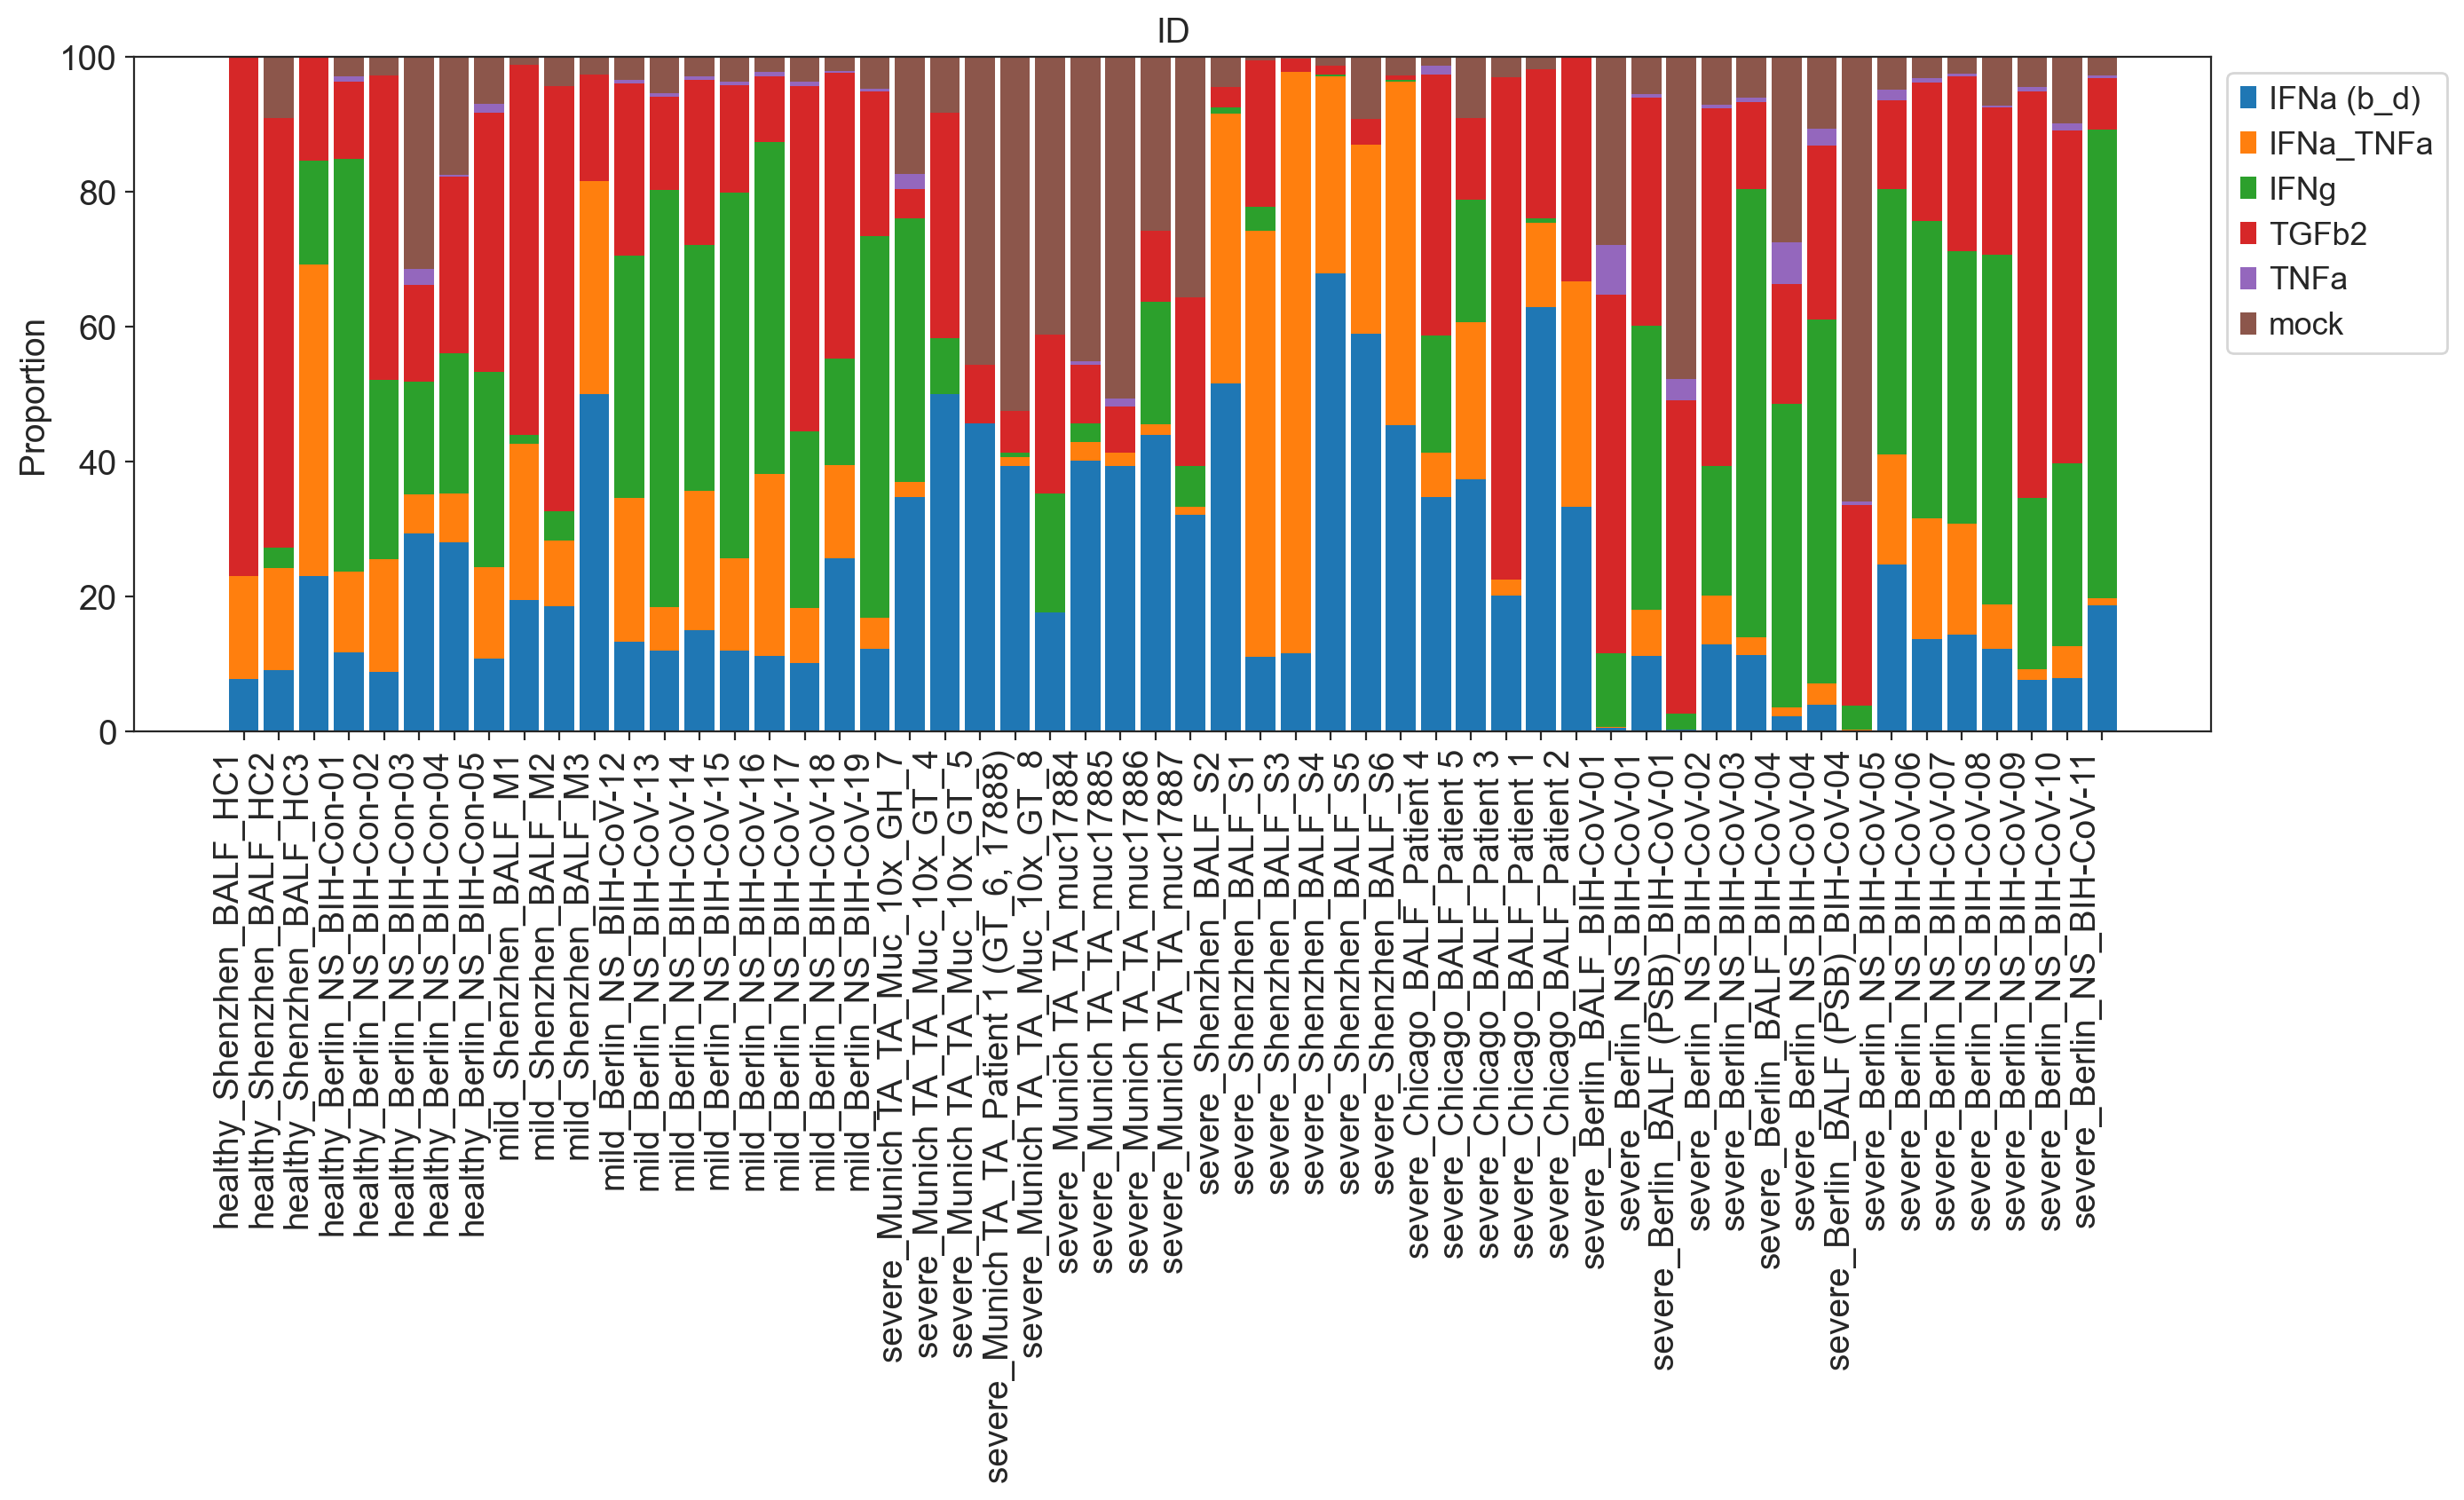

In [84]:
# for cross-check reference
l = []  # get it in the right order
for s in ['healthy', 'mild', 'severe']:
    l += list(adata[(adata.obs.batch_data == 'fischer') & (adata.obs.severity == s)].obs.ID.unique())

p = plot_proportions(
    adata[adata.obs.batch_data == 'fischer'], 'treatment_predicted', 'ID',
    figsize=(15, 5), cmap=cm.get_cmap('tab10'), level_order=l
)
# p.to_df().div(p.to_df().max(axis=1), axis=0)